In [1]:
import sys, os
sys.path.append("..")
import torch

from mune.networks import AgentModel

### config

In [2]:
modalities_config = {
    "vision": {
        "type": "vision"
    },
    "proprio": {
        "type": "proprio",
        "in_features": 4
    }
}

In [3]:
config = {
    "action_output_dim": 4,
    "modalities_config": modalities_config,
    "determ_state_dim": 200,
    "stoch_state_dim": 30,
    "min_stddev": 0.1,
    "reward_hidden_dim": 100,
    "reward_n_layers": 2,
    "value_hidden_dim": 100,
    "value_n_layers": 2,
    "action_hidden_dim": 100,
    "action_n_layers": 2
}

In [4]:
agent_model = AgentModel(**config)

In [5]:
agent_model

AgentModel(
  (encoder_modalities): ModuleDict(
    (vision): VisionEncoder(
      (conv_encoder): Sequential(
        (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
        (relu1): ReLU()
        (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (relu2): ReLU()
        (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
        (relu3): ReLU()
        (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
        (relu4): ReLU()
      )
    )
    (proprio): ProprioEncoder(
      (fc): Linear(in_features=4, out_features=32, bias=True)
    )
  )
  (decoder_modalities): ModuleDict(
    (vision): VisionDecoder(
      (fc_deter_stoch): Linear(in_features=230, out_features=1024, bias=True)
      (convt_decoder): Sequential(
        (convt1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
        (relu1): ReLU()
        (convt2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
        (relu2): ReLU()
        (convt3): Conv

## Multi-steps inference

In [44]:
%%time

observations = {
    "vision": torch.randn((1, 3, 64, 64)),
    "proprio": torch.randn((1, 4))
}

prev_action = torch.zeros(1, 4)
prev_action[:, 1] = 1

prev_determ_state = torch.randn((1, 200))
prev_stoch_state = torch.randn((1, 30))

with torch.no_grad():
    rollout_values = []
    for step in range(12):
        output = agent_model(observations=observations, 
                             prev_action=prev_action, 
                             prev_determ_state=prev_determ_state, 
                             prev_stoch_state=prev_stoch_state)
        rollout_values.append(output)
        prev_action = output['pred_action'].logits
        prev_determ_state = output['transitions']['determ_state']
        prev_stoch_state = output['transitions']['stoch_state_posterior']['stoch_state']

CPU times: user 132 ms, sys: 6.23 ms, total: 138 ms
Wall time: 81.3 ms


In [30]:
import matplotlib.pyplot as plt

In [31]:
observations

{'vision': tensor([[[[ 1.6914, -0.0216, -1.8797,  ..., -0.8505, -1.5712, -0.7464],
           [ 0.4310,  0.6654,  0.7361,  ..., -0.5825, -0.5237,  1.3260],
           [-0.4195, -0.3723, -0.7666,  ..., -0.7074,  0.3687, -0.3777],
           ...,
           [-1.3932, -0.2267, -0.9600,  ...,  1.1756, -0.8390, -0.2843],
           [ 0.8772, -0.5756, -1.2153,  ..., -1.2549, -0.3649,  1.0051],
           [-2.0285,  0.4242, -1.3816,  ..., -0.6834, -0.2649,  0.5488]],
 
          [[-1.5671,  0.0082,  1.0558,  ...,  1.3215, -1.1793,  1.0527],
           [ 0.8717, -0.7737, -1.8604,  ..., -0.4673, -0.7315, -0.3510],
           [-1.0044,  1.0602, -1.0290,  ..., -1.0491,  0.5306, -0.6638],
           ...,
           [-1.0228, -1.5134, -0.8837,  ..., -0.8053, -1.0840,  0.0282],
           [-0.9791,  1.1291,  0.4724,  ..., -0.0481,  0.2393, -0.0139],
           [ 1.6039,  0.3393,  0.4232,  ..., -1.3762,  1.1795,  0.8392]],
 
          [[ 0.2165, -1.1680,  0.3416,  ..., -0.0826, -0.2718,  0.4840],
   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


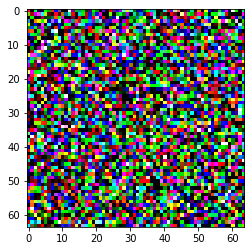

In [32]:
plt.imshow(observations['vision'].squeeze(0).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


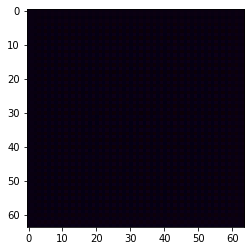

In [39]:
plt.imshow(rollout_values[11]['pred_observations']['vision'].squeeze(0).permute(1, 2, 0))